<a href="https://colab.research.google.com/github/maryisangediok/Computer-Vision/blob/main/skinCancer_vgg100_100ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, time
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from tensorflow.keras.applications import VGG16, VGG19, InceptionResNetV2

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/')  # Add the path to 'ham.py' in your Drive
from ham import get_default_dataset, create_dataset, classes


In [ ]:
# Input features for your images
height = width = 100 # Only change this line if using a different image size
channel = 3
input_shape = (height, width, channel)
reshape = (-1,height,width,channel)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
def collect_data(input_shape, resize=None):
    if resize is not None:
        height, width, channel = resize
    else:
        height, width, channel = input_shape

    # Use default dataset or generate the dataset (if using a different shape)
    if height == width == 28:
        data, testset, data_meta, testset_meta = get_default_dataset()
    else:
        data, testset, data_meta, testset_meta = create_dataset(resize=(height, width))

    y = data['label']
    x = data.drop(columns=['label'])

    # This process ensures that all the input features have the same scale,
    # which can help the model learn more effectively and prevent some features from dominating others.
    x = x.astype("float32") / 255.0
    x = np.array(x).reshape((-1, height, width, channel))

    return x, y, testset
#collect data
x, y, testset = collect_data(input_shape)

Downloading...
From: https://drive.google.com/uc?id=1vNLwZ4ao7eZTAeH0JRIhaZ1QbiP3LsDG
To: /content/file.zip
100%|██████████| 1.37G/1.37G [00:34<00:00, 40.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1w6eRHc4sKJ1jzh5gU112HK8mfgraqcIj
To: /content/file.zip
100%|██████████| 1.40G/1.40G [00:29<00:00, 48.2MB/s]


In [ ]:
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Split the data into training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=1)

# Find the classes with fewer samples (minority classes)
unique_classes, class_counts = np.unique(Y_train, return_counts=True)
minority_classes = unique_classes[class_counts < np.max(class_counts)]

# Data augmentation using ImageDataGenerator
augmented_images = []
augmented_labels = []

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to the samples of the minority classes
for minority_class in minority_classes:
    class_indices = np.where(Y_train == minority_class)[0]
    for idx in class_indices:
        img = X_train[idx]
        img = img.reshape((1,) + img.shape)  # Convert to 4D array (batch size, height, width, channels)
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            augmented_labels.append(minority_class)
            break  # Generate only one augmented image per original image

# Convert augmented images and labels to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine the original and augmented samples to create a balanced dataset
X_train = np.concatenate((X_train, augmented_images))
Y_train = np.concatenate((Y_train, augmented_labels))
'''

In [ ]:
def preprocess_data(x,y):
    # Split the data into training and validation sets
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=1)

    oversample = RandomOverSampler()
    # Reshape X_train to 2 dimensions
    X_train_flat = X_train.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])

    # Apply oversampling to the flattened X_train
    X_train_resampled, Y_train_resampled = oversample.fit_resample(X_train_flat, Y_train)
    # Reshape the flattened X_train_resampled back to its original shape
    X_train_resampled_reshaped = X_train_resampled.reshape(-1, x.shape[1], x.shape[2], x.shape[3])

    return X_train_resampled_reshaped, X_test, Y_train_resampled, Y_test

#preprocess data
X_train, X_test, Y_train, Y_test = preprocess_data(x,y)


In [ ]:
def train_model(model, X_train, Y_train):
    callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_accuracy', mode='max',
                                                  verbose=1)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size=128,
                        epochs=100,
                        callbacks=[callback])

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('model_accuracy.png')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('model_loss.png')
    plt.show()

    model.save('best_model.h5')
    model.save_weights('best_model_weights.h5')

    model = tf.keras.models.load_model('best_model.h5')
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    open("best_model.tflite", "wb").write(tflite_model)


In [ ]:
def evaluate_model(model, X_test, Y_test):
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)

    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    confusion_mtx = confusion_matrix(Y_test, Y_pred_classes)

    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes.values())

    print('Validation Set Evaluation:')
    print(classification_report(np.float32(Y_test), Y_pred_classes.round()))


In [ ]:
def save_model(model, model_name):
    # Save model architecture
    model_json = model.to_json()
    with open(f"{model_name}.json", "w") as json_file:
        json_file.write(model_json)

    # Save model weights
    model.save_weights(f"{model_name}_weights.h5")
    print(f"Model saved as {model_name}.json and {model_name}_weights.h5")


def load_model(model_name):
    # Load model architecture
    json_file = open(f"{model_name}.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)

    # Load model weights
    loaded_model.load_weights(f"{model_name}_weights.h5")
    print(f"Model loaded from {model_name}.json and {model_name}_weights.h5")
    return loaded_model


def convert_to_tflite(model, model_name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(f"{model_name}.tflite", "wb") as tflite_file:
        tflite_file.write(tflite_model)
    print(f"Model converted to TensorFlow Lite format and saved as {model_name}.tflite")


In [ ]:
def test_model(model, testset):
    Y_testset = testset['label']
    X_testset = testset.drop(columns=['label'])

    X_testset = np.array(X_testset).reshape(reshape)
    X_testset = X_testset.astype("float32") / 255.0

    loss, accuracy = model.evaluate(X_testset, Y_testset, verbose=2)

    # Make predictions using the model
    Y_testset_pred = model.predict(X_testset)
    Y_testset_pred_classes = np.argmax(Y_testset_pred, axis=1)

    # Plot the confusion matrix
    confusion_mtx = confusion_matrix(Y_testset, Y_testset_pred_classes)
    plot_confusion_matrix(confusion_mtx, classes.values())

    print('Test Set Evaluation:')
    print(classification_report(Y_testset, Y_testset_pred_classes))


# VGG16

Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.6184
Epoch 1: saving model to best_model.h5
67/67 [==============================] - 5s 50ms/step - loss: 1.1975 - accuracy: 0.6184 - val_loss: 2.2903 - val_accuracy: 0.0455
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.0241 - accuracy: 0.6473
Epoch 2: saving model to best_model.h5
67/67 [==============================] - 2s 28ms/step - loss: 1.0241 - accuracy: 0.6473 - val_loss: 2.3006 - val_accuracy: 0.0826
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9598 - accuracy: 0.6643
Epoch 3: saving model to best_model.h5
67/67 [==============================] - 2s 28ms/step - loss: 0.9598 - accuracy: 0.6643 - val_loss: 2.0413 - val_accuracy: 0.1341
Epoch 4/25
67/67 [==============================] - ETA: 0s - loss: 0.9248 - accuracy: 0.6754
Epoch 4: saving model to best_model.h5
67/67 [==============================] - 2s 28ms/step - loss: 0.9248 - accurac

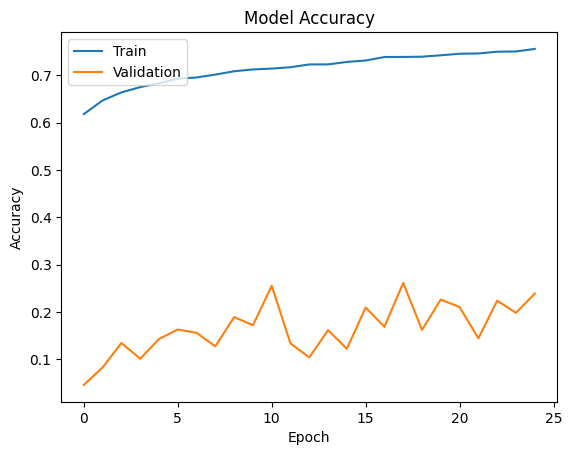

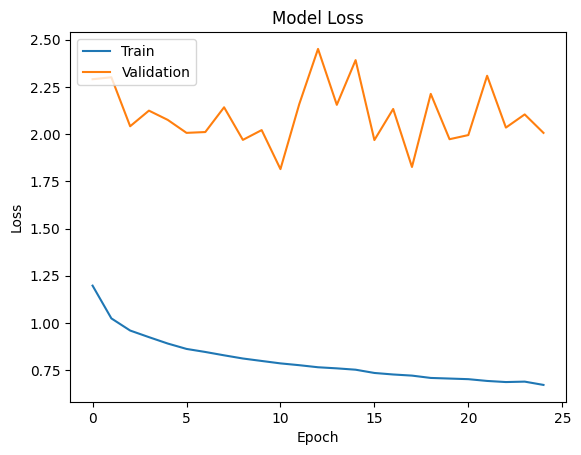

TypeError: ignored

In [ ]:
# Pretrained VGG16 model
base_model_vgg16 = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_vgg16.trainable = False

# Build your VGG16 model on top of the base model
model_vgg16 = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Train and validate the VGG16 model
train_model(model_vgg16, X_train, Y_train)

# Evaluate the VGG16 model on test set
evaluate_model(model_vgg16, X_test, Y_test)

#Test model
test_model(model_vgg16, testset)

# VGG19

80134624/80134624 [==============================] - 5s 0us/step
Epoch 1/25
235/235 [==============================] - ETA: 0s - loss: 1.5624 - accuracy: 0.3990
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 9s 33ms/step - loss: 1.5624 - accuracy: 0.3990 - val_loss: 2.2452 - val_accuracy: 0.2742
Epoch 2/25
233/235 [============================>.] - ETA: 0s - loss: 1.2540 - accuracy: 0.5435
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 7s 29ms/step - loss: 1.2538 - accuracy: 0.5436 - val_loss: 1.9827 - val_accuracy: 0.3290
Epoch 3/25
234/235 [============================>.] - ETA: 0s - loss: 1.1148 - accuracy: 0.6011
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 7s 29ms/step - loss: 1.1145 - accuracy: 0.6013 - val_loss: 1.6758 - val_accuracy: 0.3784
Epoch 4/25
235/235 [==============================] - ETA: 0s - loss: 1.0175 - accuracy: 0.6418
Epoch 4: saving model to best_model.h5

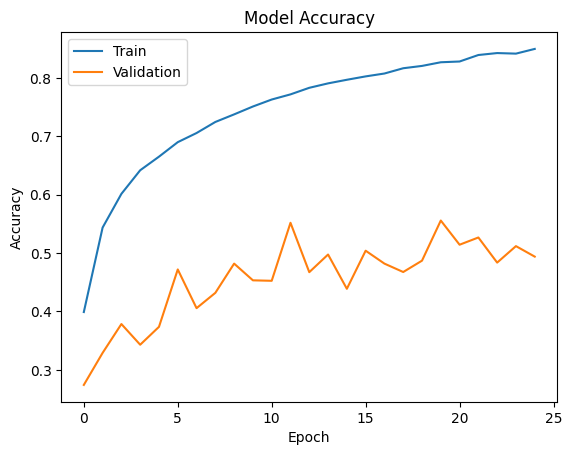

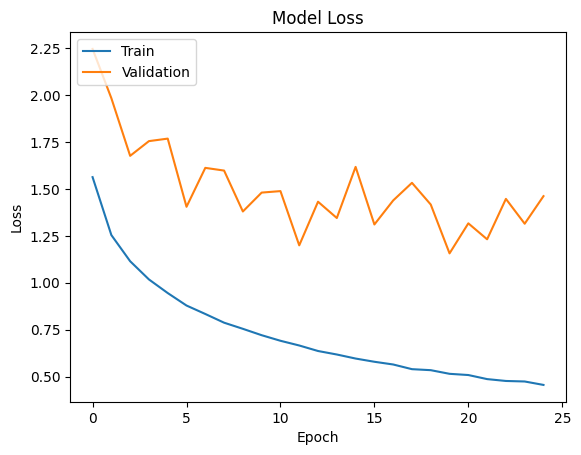

63/63 - 0s - loss: 1.1160 - accuracy: 0.6615 - 484ms/epoch - 8ms/step
63/63 [==============================] - 1s 6ms/step
Validation Set Evaluation:
              precision    recall  f1-score   support

         0.0       0.28      0.52      0.36        65
         1.0       0.43      0.57      0.49       103
         2.0       0.31      0.66      0.42       220
         3.0       0.24      0.48      0.32        23
         4.0       0.90      0.76      0.83      1341
         5.0       0.56      0.89      0.68        28
         6.0       0.60      0.13      0.21       223

    accuracy                           0.66      2003
   macro avg       0.47      0.57      0.47      2003
weighted avg       0.75      0.66      0.67      2003

48/48 - 0s - loss: 1.4649 - accuracy: 0.6029 - 357ms/epoch - 7ms/step
48/48 [==============================] - 0s 6ms/step
Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.17      0.44      0.24        43


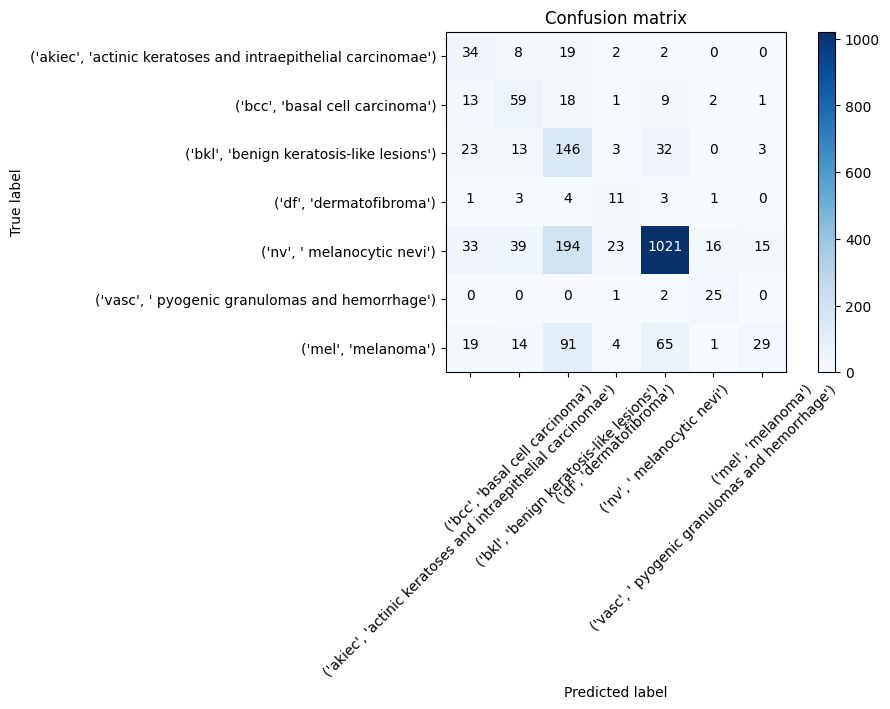

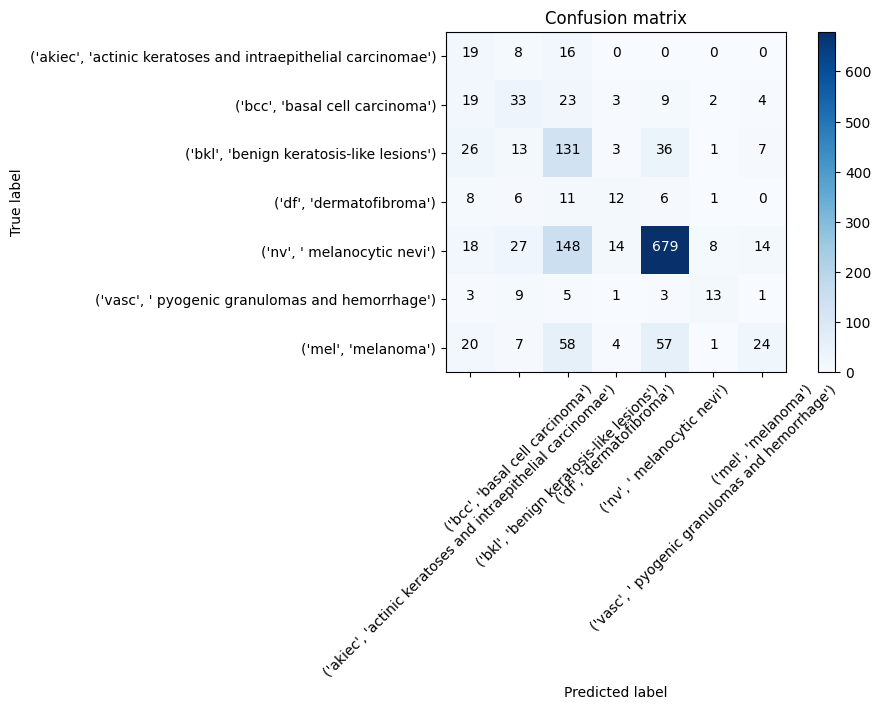

In [ ]:
# Pretrained VGG19 model
base_model_vgg19 = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_vgg19.trainable = False

# Build your VGG19 model on top of the base model
model_vgg19 = Sequential([
    base_model_vgg19,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Train and validate the VGG19 model
train_model(model_vgg19, X_train, Y_train)

# Evaluate the VGG19 model on test set
evaluate_model(model_vgg19, X_test, Y_test)


#Test model
test_model(model_vgg19, testset)

# InceptionResNetV2

Epoch 1/25
234/235 [============================>.] - ETA: 0s - loss: 1.0801 - accuracy: 0.6275
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 24s 58ms/step - loss: 1.0787 - accuracy: 0.6279 - val_loss: 1.9039 - val_accuracy: 0.3905
Epoch 2/25
234/235 [============================>.] - ETA: 0s - loss: 0.5995 - accuracy: 0.7966
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 8s 35ms/step - loss: 0.5998 - accuracy: 0.7964 - val_loss: 1.4757 - val_accuracy: 0.4735
Epoch 3/25
235/235 [==============================] - ETA: 0s - loss: 0.4278 - accuracy: 0.8604
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 8s 35ms/step - loss: 0.4278 - accuracy: 0.8604 - val_loss: 1.3067 - val_accuracy: 0.5379
Epoch 4/25
233/235 [============================>.] - ETA: 0s - loss: 0.3272 - accuracy: 0.8963
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 8s 34ms/step - loss:

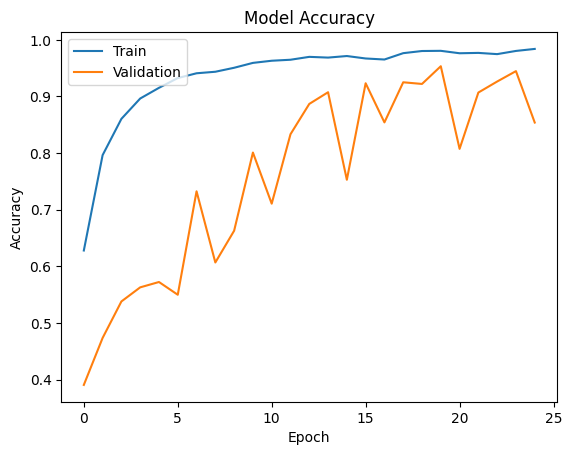

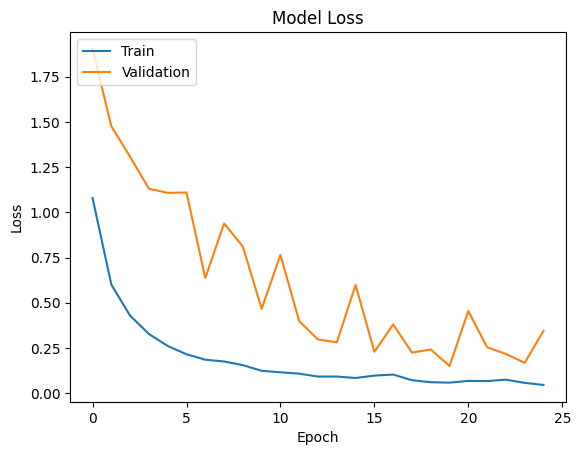

63/63 - 1s - loss: 2.5617 - accuracy: 0.6955 - 1s/epoch - 18ms/step
63/63 [==============================] - 5s 19ms/step
Validation Set Evaluation:
              precision    recall  f1-score   support

         0.0       0.18      0.20      0.19        65
         1.0       0.40      0.38      0.39       103
         2.0       0.38      0.33      0.35       220
         3.0       0.43      0.13      0.20        23
         4.0       0.81      0.90      0.85      1341
         5.0       0.56      0.50      0.53        28
         6.0       0.41      0.21      0.28       223

    accuracy                           0.70      2003
   macro avg       0.45      0.38      0.40      2003
weighted avg       0.67      0.70      0.67      2003

48/48 - 1s - loss: 4.6706 - accuracy: 0.6267 - 906ms/epoch - 19ms/step
48/48 [==============================] - 1s 20ms/step
Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.16      0.19      0.17        43

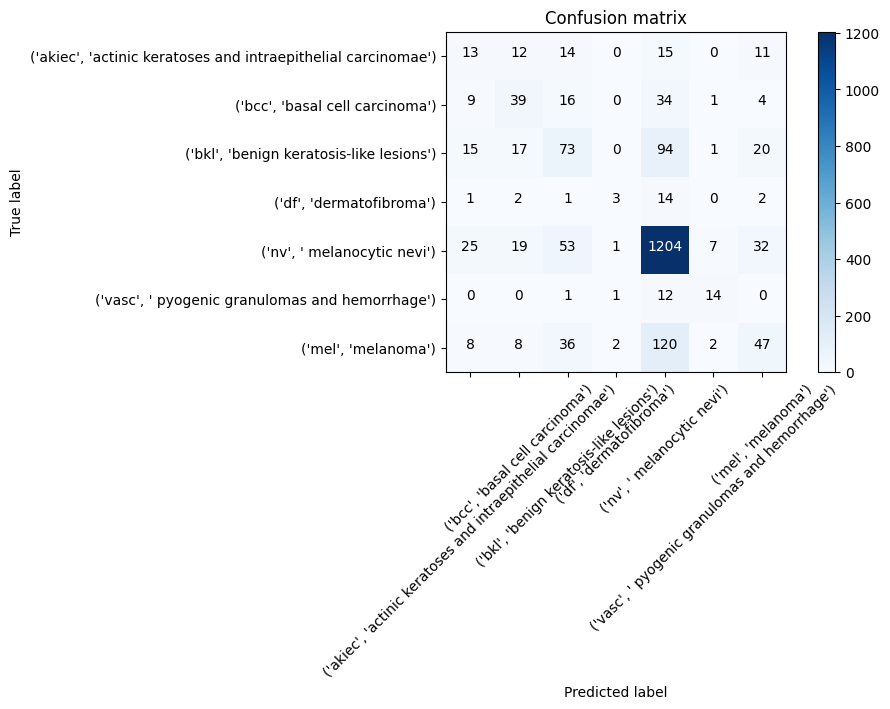

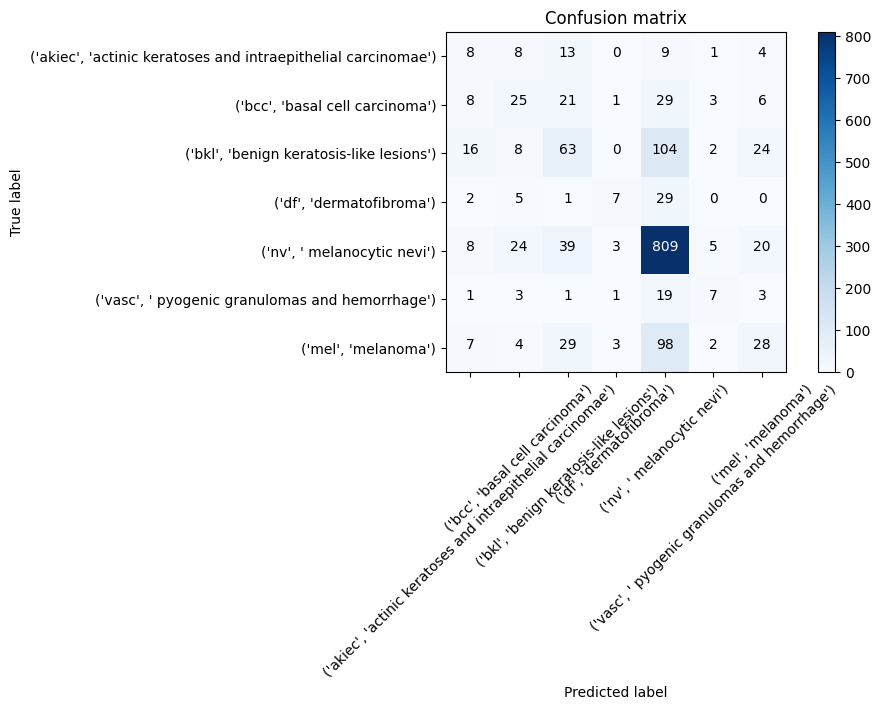

In [ ]:
# Pretrained InceptionResNetV2 model
base_model_inceptionresnetv2 = InceptionResNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_inceptionresnetv2.trainable = False

# Build your InceptionResNetV2 model on top of the base model
model_inceptionresnetv2 = Sequential([
    base_model_inceptionresnetv2,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Train and validate the InceptionResNetV2 model
train_model(model_inceptionresnetv2, X_train, Y_train)

# Evaluate the InceptionResNetV2 model on test set
evaluate_model(model_inceptionresnetv2, X_test, Y_test)

#Test model
test_model(model_inceptionresnetv2, testset)
